In [ ]:
import os 
import warnings
import gc
import pandas as pd 
import numpy as np 
from plotly.subplots import make_subplots
import plotly.express as px 
import plotly.graph_objects as go
import xgboost 
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.svm import SVC

# Configuration
warnings.simplefilter('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_PATH = "/content/drive/MyDrive/Orig_synthetic_data.csv"

In [ ]:
# Utility functions 
def describe(df, stats):
    '''Describe the basic information of the raw dataframe.
    
    Parameters:
        df: pd.DataFrame, raw dataframe to be analyzed
        stats: boolean, whether to get descriptive statistics 
    
    Return:
        None
    '''
    df_ = df.copy(deep=True)   # Copy of the raw dataframe
    n_features = df_.shape[1]
    if n_features > pd.get_option("max_columns"):
        # If the feature (column) number is greater than max number of columns displayed
        warnings.warn("Please reset the display-related options max_columns \
                      to enable the complete display.", 
                      UserWarning) 
    print("=====Basic information=====")
    display(df_.info())
    get_nan_ratios(df_)
    if stats:
        print("=====Description=====")
        numeric_col_num = df_.select_dtypes(include=np.number).shape[1]   # Number of cols in numeric type
        if numeric_col_num != 0:
            display(df_.describe())
        else:
            print("There's no description of numeric data to display!")
    del df_
    gc.collect()

def get_nan_ratios(df):
    '''Get NaN ratios of columns with NaN values.
    
    Parameters:
        df: pd.DataFrame, raw dataframe to be analyzed
        
    Return:
        None
    '''
    df_ = df.copy()   # Copy of the raw dataframe
    nan_ratios = df_.isnull().sum() / df_.shape[0] * 100   # Ratios of value nan in each column
    nan_ratios = pd.DataFrame([df_.columns, nan_ratios]).T   # Take transpose 
    nan_ratios.columns = ["Columns", "NaN ratios"]
    nan_ratios = nan_ratios[nan_ratios["NaN ratios"] != 0.0]
    print("=====NaN ratios of columns with NaN values=====")
    if len(nan_ratios) == 0:
        print("There isn't any NaN value in the dataset!")
    else:
        display(nan_ratios)
    del df_
    gc.collect()

## Separate data for train (Syntehtic Data) and test (Orignal data)

In [ ]:
# Read the training and testing CSV files
train_df = pd.read_csv("/content/drive/MyDrive/orig_synthetic_data.csv")
test_df = pd.read_csv("/content/drive/MyDrive/IDS_Data1.csv")

# Split the data into features and target
X_train, y_train = train_df.iloc[:, :-1], train_df['class']
# Split the data into features and target
X = test_df.iloc[:, :-1]
y = test_df['class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)




# Optional: Reset index if needed
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Print the shapes of the training and testing data
print(f"Shape of X_train: {X_train.shape}\nShape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}\nShape of y_test: {y_test.shape}")

Shape of X_train: (16878, 15)
Shape of X_test: (8314, 15)
Shape of y_train: (16878,)
Shape of y_test: (8314,)


In [ ]:
print("=====DataFrame: X_train=====")
display(X_train.head())
# describe(X_train["SrcPkts","SrcBytes"], stats=True)

=====DataFrame: X_train=====


,Sport,TotPkts,TotBytes,SrcPkts,DstPkts,SrcBytes,service,flag,protocol_type,count,srv_count,dst_host_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_bytes
0,53075,20,1276,10,10,644,private,S0,tcp,125,18,255,0.08,0.07,0
1,49199,20,1276,10,10,644,http,SF,tcp,8,9,255,1.00,0.00,762
2,57400,18,1152,10,8,644,discard,S0,tcp,211,20,255,0.08,0.08,0
3,59612,20,1276,10,10,644,private,S0,tcp,191,3,255,0.01,0.08,0
4,62248,18,1152,10,8,644,other,SF,udp,240,240,240,1.00,0.00,4


In [ ]:
from sklearn.preprocessing import LabelEncoder
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Specify the columns that need to be label encoded
columns_to_encode = ['service', 'flag', 'protocol_type']

# Iterate over the columns and apply label encoding
for column in columns_to_encode:
    # Fit label encoder on the unique values of the column
    label_encoder.fit(X_train[column])
    
    # Transform the column values using label encoder
    X_train[column] = label_encoder.transform(X_train[column])

# Print the updated dataset
print(X_train)

       Sport  TotPkts  TotBytes  SrcPkts  DstPkts  SrcBytes  service  flag  \
0      53075       20      1276       10       10       644       45     5   
1      49199       20      1276       10       10       644       22     9   
2      57400       18      1152       10        8       644        9     5   
3      59612       20      1276       10       10       644       45     5   
4      62248       18      1152       10        8       644       40     9   
...      ...      ...       ...      ...      ...       ...      ...   ...   
16873  59930       20      1276       10       10       644       11     9   
16874  60276       20      1276       10       10       644       50     9   
16875  55790       20      1276       10       10       644       22     1   
16876  54199       20      1276       10       10       644       22     9   
16877  61989       18      1152       10        8       644       45     5   

       protocol_type  count  srv_count  dst_host_count  \
0    

In [ ]:
X_train.shape

(16878, 15)

In [ ]:
cat_features = ['protocol_type', 'service', 'flag']
for f in cat_features:
    print(f"=====Unique values of {f}=====")
    unique_vals = X_train[f].unique()
    print(unique_vals)
    print(f"Number of unique values: {len(unique_vals)}\n")

=====Unique values of protocol_type=====
[1 2 0]
Number of unique values: 3

=====Unique values of service=====
[45 22  9 40 14 53 13 54 19 50 18 25 11 23 56 32 60 34 63  8 15 16 17 58
  5 27 28  2 61 30 64  3 26 31 35  4 21 43 62  0 10 51 55 37  6 36 38 29
 24 39 33 47 42 12  7 20 52 57 48 41  1 49 44 46 59]
Number of unique values: 65

=====Unique values of flag=====
[ 5  9  1  4  6  3  2 10  8  0  7]
Number of unique values: 11



In [ ]:
for f in cat_features:
    val_counts = X_train[f].value_counts()
    fig = go.Figure()
    fig.add_trace(go.Pie(
        labels=val_counts.index,
        values=val_counts
    ))
    fig.update_traces(textposition='inside') 
    fig.update_layout(
        title=f"Pie Chart of {f}",
        uniformtext_minsize=12, 
        uniformtext_mode='hide'
    )
    fig.show()

In [ ]:
numeric_features = [col for col in X_train.columns]

fig = make_subplots(rows=10, cols=4, subplot_titles=numeric_features)
for i in range(1, 11):
    for j in range(1, 5):
        feature_idx = 4 * (i-1) + (j-1)
        if feature_idx == len(numeric_features) or feature_idx>14:
            break
        feature = numeric_features[feature_idx]
        feature_series = X_train[feature]
        sub_fig = go.Histogram(x=feature_series, name=feature)
        fig.add_trace(
            sub_fig,
            row=i,
            col=j
        )
        
fig.update_layout(height=1200, title_text="Univariate Distribution of Numeric Features") 
fig.show()

In [ ]:
n_samples = X_train.shape[0]   # Total number of samples

# Get the proportion of the value with the most count in each feature
max_proportions = pd.DataFrame()
for f in numeric_features:
    feature_series = X_train[f]
    max_proportion = np.max(feature_series.value_counts()) / n_samples
    max_proportions[f] = [max_proportion]
max_proportions.index = ["Max Proportion"]

# Get the variance of each feature 
vars = pd.DataFrame(X_train.var()).T
vars.index = ["Variance"]

disp_and_var = max_proportions.append(vars)
print("=====Statistical dispersion and variation=====")
display(disp_and_var)

=====Statistical dispersion and variation=====


,Sport,TotPkts,TotBytes,SrcPkts,DstPkts,SrcBytes,service,flag,protocol_type,count,srv_count,dst_host_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_bytes
Max Proportion,3.614172e-03,0.516353,5.163526e-01,0.990876,0.516412,9.906979e-01,0.314848,0.594798,0.813485,0.220287,0.202512,0.589406,0.384820,0.369001,5.398744e-01
Variance,4.472729e+07,247.108975,1.754560e+07,82.344324,44.946288,9.224980e+06,229.728043,7.179670,0.183555,13015.476278,5162.187145,9801.589398,0.201305,0.034903,5.145233e+09


In [ ]:
# Filter out features with high "max proportion" or low "variance"
disp_and_var_T = disp_and_var.T   # Take the transpose
features_remained = disp_and_var_T[(disp_and_var_T['Max Proportion'] < 0.99) & disp_and_var_T['Variance'] > 0.001].index.tolist()
X_train = X_train.loc[:, features_remained]
print(f"After filtering, there are {len(features_remained)} numeric features remained.")

# Plot bivariate distributions 
features_picked = features_remained[-5:]
df_train = X_train.loc[:, features_picked]
df_train['gt'] = y_train
fig = px.scatter_matrix(df_train, 
                        dimensions=features_picked,
                        color="gt", 
                        symbol="gt")
fig.update_traces(diagonal_visible=False)
fig.update_layout(height=1200, title_text="Bivariate Distribution of Numeric Feature Pairs (Randomly Picked)") 
fig.show()

After filtering, there are 13 numeric features remained.


In [ ]:
class_count = pd.DataFrame(y_train).value_counts()
fig = go.Figure()
fig.add_trace(go.Pie(
    labels=class_count.index,
    values=class_count
))
fig.update_traces(textposition='inside') 
fig.update_layout(
    title=f"Pie Chart of Groundtruths",
    uniformtext_minsize=12, 
    uniformtext_mode='hide'
)
fig.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
X_train_Encoded = X_train.astype(float)

In [ ]:
X_train.shape

(16878, 13)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Specify the columns that need to be label encoded
columns_to_encode = ['service', 'flag', 'protocol_type']

# Iterate over the columns and apply label encoding
for column in columns_to_encode:
    # Fit label encoder on the unique values of the column
    label_encoder.fit(X_test[column])
    
    # Transform the column values using label encoder
    X_test[column] = label_encoder.transform(X_test[column])

# Print the updated dataset
print(X_test)

      Sport  TotPkts  TotBytes  SrcPkts  DstPkts  SrcBytes  service  flag  \
0     57440       20      1276       10       10       644       14     8   
1     49576       18      1152       10        8       644       22     0   
2     61395       20      1276       10       10       644       46     4   
3     57882       18      1152       10        8       644       11     8   
4     51760       20      1276       10       10       644       22     4   
...     ...      ...       ...      ...      ...       ...      ...   ...   
8309  59003       20      1276       10       10       644       46     0   
8310  61281       20      1276       10       10       644       46     4   
8311  53337       20      1276       10       10       644       11     8   
8312  56568       20      1276       10       10       644       51     8   
8313  61017       18      1152       10        8       644       11     8   

      protocol_type  count  srv_count  dst_host_count  dst_host_same_srv_ra

In [ ]:
X_test_Encoded = X_test.astype(float)

In [ ]:
X_train_Encoded.shape

(16878, 13)

In [ ]:
y_train.head()

0    anomaly
1     normal
2    anomaly
3    anomaly
4     normal
Name: class, dtype: object

In [ ]:
y_test.shape

(8314,)

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train.values)

In [ ]:
y_test_encoded =  label_encoder.fit_transform(y_test.values)

In [ ]:
X_test.shape

(8314, 15)

In [ ]:
print(type(y_train_encoded))

<class 'numpy.ndarray'>


In [ ]:
# Convert the data into PyTorch tensors
X_train_tensor = torch.tensor(X_train_Encoded.values)
y_train_tensor = torch.tensor(y_train_encoded)
X_val_tensor = torch.tensor(X_test_Encoded.values)
y_val_tensor = torch.tensor(y_test_encoded)

In [ ]:
X_val_tensor.shape

torch.Size([8314, 15])

In [ ]:
y_val_tensor.shape

torch.Size([8314])

In [ ]:
# Adjust the size of X_val_tensor to match y_val_tensor
X_val_tensor = X_val_tensor[:y_val_tensor.shape[0]]

# Verify the shapes
print("X_val_tensor shape:", X_val_tensor.shape)
print("y_val_tensor shape:", y_val_tensor.shape)

X_val_tensor shape: torch.Size([8314, 15])
y_val_tensor shape: torch.Size([8314])


In [ ]:
# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

In [ ]:
# Create DataLoader objects
batch_size = 64  # Adjust the batch size according to your dataset and available resources
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
from torch.nn.modules.activation import ReLU
class CNN1D(nn.Module):
    def __init__(self, input_size):
        super(CNN1D, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2),

        )

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension
        x = x.float()  # Convert the input to float type
        x = self.model(x)

        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 13
num_classes = 2

In [ ]:
model = CNN1D(input_size).to(device)

In [ ]:
print(model)

CNN1D(
  (model): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=128, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Epoch [1/200], Step [50/264], Loss: 1.3047
Epoch [1/200], Step [100/264], Loss: 0.7846
Epoch [1/200], Step [150/264], Loss: 1.7294
Epoch [1/200], Step [200/264], Loss: 0.4119
Epoch [1/200], Step [250/264], Loss: 1.1772
Epoch [2/200], Step [50/264], Loss: 0.8351
Epoch [2/200], Step [100/264], Loss: 1.3013
Epoch [2/200], Step [150/264], Loss: 1.9191
Epoch [2/200], Step [200/264], Loss: 0.4749
Epoch [2/200], Step [250/264], Loss: 4.8812
Epoch [3/200], Step [50/264], Loss: 1.4313
Epoch [3/200], Step [100/264], Loss: 3.7535
Epoch [3/200], Step [150/264], Loss: 0.7490
Epoch [3/200], Step [200/264], Loss: 6.4429
Epoch [3/200], Step [250/264], Loss: 3.0934
Epoch [4/200], Step [50/264], Loss: 1.1349
Epoch [4/200], Step [100/264], Loss: 9.2873
Epoch [4/200], Step [150/264], Loss: 2.7509
Epoch [4/200], Step [200/264], Loss: 0.4772
Epoch [4/200], Step [250/264], Loss: 2.0373
Epoch [5/200], Step [50/264], Loss: 0.4600
Epoch [5/200], Step [100/264], Loss: 3.0961
Epoch [5/200], Step [150/264], Loss: 

Epoch [200/200], Step [200/264], Loss: 0.1769
Epoch [200/200], Step [250/264], Loss: 0.0284


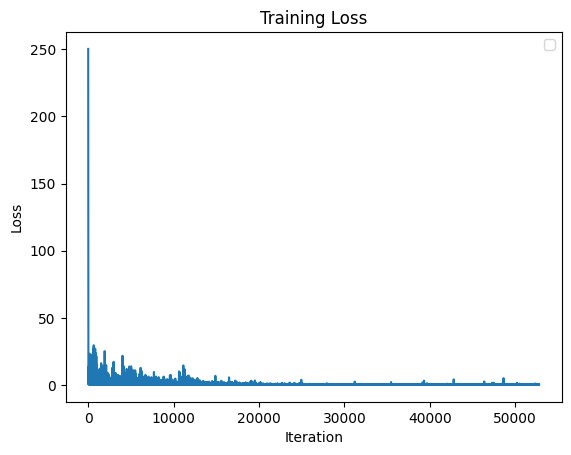

In [ ]:
import matplotlib.pyplot as plt

num_epochs = 200
total_step = len(train_loader)
losses = []

criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 50 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
        
        losses.append(loss.item())

# Plot the losses
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Process the data to meet the model input
X_test = X_test.loc[:, features_remained]

X_test = X_test.loc[:, features_remained]

def mapping(val):
    temp = {'normal': 1, 'anomaly': 0}
    return int(temp[val])

# Map the values in y_test to integers
y_test_temp = list(map(mapping, y_test))

# Create a LabelEncoder object
label_encoder = LabelEncoder()
# Convert the features to integers
X_test = X_test.astype(float)

# Convert X_test to tensor
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float).to(device)

# Set the model to evaluation mode
model.eval()

# Forward pass on the test data
with torch.no_grad():
    outputs = model(X_test_tensor)
    y_test_pred = torch.argmax(outputs, dim=1).cpu().numpy()

# Calculate accuracy
accuracy = accuracy_score(y_test_temp, y_test_pred)

# Summarize the performance evaluated on the testing set
print("===== Evaluation metrics on the testing set =====")
print('Accuracy:', accuracy)

# Calculate precision, recall, and F1-score
for method in ['macro', 'micro', 'weighted']:
    print(f"===== Metrics {method.capitalize()} =====")
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_temp, y_test_pred, average=method)
    print(f"Precision = {precision:.4f} | Recall = {recall:.4f} | F1-score = {f1_score:.4f}")

===== Evaluation metrics on the testing set =====
Accuracy: 0.9606687515034881
===== Metrics Macro =====
Precision = 0.9633 | Recall = 0.9586 | F1-score = 0.9603
===== Metrics Micro =====
Precision = 0.9607 | Recall = 0.9607 | F1-score = 0.9607
===== Metrics Weighted =====
Precision = 0.9618 | Recall = 0.9607 | F1-score = 0.9606


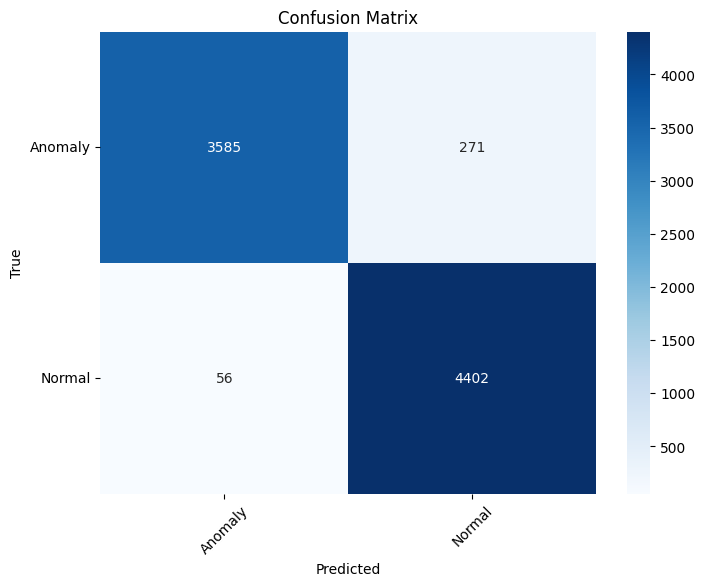

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_test_temp, y_test_pred)

# Define class labels
class_labels = ['Anomaly', 'Normal']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)

# Set labels, title, and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)

# Rotate tick labels for better visibility
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Show the plot
plt.show()